In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from scipy.io.arff import loadarff
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

np.random.seed(0)

In [2]:
datasets_df = pd.read_csv('OpenML/data.csv')
datasets_df.head()

,id,name,length,target
0,10,lymph,22513,class
1,1000,hypothyroid,276707,binaryClass
2,1001,sponge,41487,binaryClass
3,1002,ipumslasmall,2622855,binaryClass
4,1003,primarytumor,22769,binaryClass


In [3]:
datasets_df.target.value_counts()

binaryClass                 305
class                       195
Class                       131
Tissue                       45
oz1143                       22
                           ... 
Activity                      1
oz252                         1
oz629                         1
oz54                          1
Who_Pays_for_Access_Work      1
Name: target, Length: 264, dtype: int64

In [4]:
datasets_df = datasets_df[datasets_df.target.isin(['binaryClass', 'class', 'Class'])]
len(datasets_df)

631

In [93]:
def mk_basic_features(xs, ys):
    assert len(xs) == len(ys)
    num_instances = xs.shape[0]
    num_features = xs.shape[1]
    num_numeric_features = xs.select_dtypes(include=[np.number]).shape[1]
    num_cat_features = num_features - num_numeric_features
    freq_numeric_features = num_numeric_features / num_features
    freq_cat_features = num_cat_features / num_features
    num_classes = ys.nunique()
    return {
        'num_instances': num_instances,
        'num_features': num_features,
        'freq_numeric_features': freq_numeric_features,
        'freq_cat_features': freq_cat_features,
        'num_classes': num_classes
    }

In [94]:
def mk_statistical_features(xs, prefix='base__', need_floats=True, need_cats=True):
    agg_functions = [np.min, np.max, np.mean, np.std, np.var, np.median, stats.skew, stats.kurtosis]
    def mk_floats():
        agg_features = xs.select_dtypes(include=[np.number])
        res = {}
        for f1 in agg_functions:
            for f2 in agg_functions:
                if len(agg_features.columns) == 0:
                    res[f'{prefix}{f1.__name__}__{f2.__name__}'] = 0.0
                else:
                    conv1 = np.round(f1(agg_features, axis=1), 5)
                    conv2 = np.round(f2(conv1), 5)
                    res[f'{prefix}{f1.__name__}__{f2.__name__}'] = conv2
        return res

    def mk_cats():
        agg_features = xs.select_dtypes(exclude=[np.number])
        entropies = []
        res = {}
        for col in agg_features.columns:
            entropies.append(stats.entropy(agg_features[col].value_counts(normalize=True), base=2))
        for f in agg_functions:
            if len(entropies) == 0:
                res[f'{prefix}cat_entropy__{f.__name__}'] = 0.0
            else:
                res[f'{prefix}cat_entropy__{f.__name__}'] = np.round(np.round(f(entropies), 5), 5)
        return res

    return {**(mk_floats() if need_floats else {}), **(mk_cats() if need_cats else {})}

In [95]:
def encode_and_bind(df, feature_to_encode):
    dummies = pd.get_dummies(df[feature_to_encode].apply(lambda x: feature_to_encode + '_' + x.decode("utf-8")))
    res = pd.concat([df, dummies], axis=1)
    return res.drop(feature_to_encode, axis=1)

def mk_structural_features(xs, ys):
    def mk_svc(X, y):
        clf = SVC()
        clf.fit(X, y)
        all_coefs = pd.DataFrame(np.round(clf.dual_coef_, 4))
        return {**mk_statistical_features(all_coefs, need_cats=False, prefix='svm__'),
                'score__svm_clf': np.round(clf.score(X, y), 3)}

    data = xs.copy()
    cat_data = data.select_dtypes(exclude=[np.number])
    for cat_name in cat_data.columns:
        data = encode_and_bind(data, cat_name)

    dt_res = {}# mk_decision_tree(data, ys)

    scaler = sklearn.preprocessing.StandardScaler()
    scaled = scaler.fit_transform(data)

    logreg_res = mk_svc(scaled, ys)

    return {**dt_res, **logreg_res}

In [96]:
def get_label(X, y):
    algorithms = [
        DecisionTreeClassifier(),
        LogisticRegressionCV(),
        GradientBoostingClassifier()
    ]

    names = ['DT', 'LogReg', 'GBDT']

    data = X.copy()
    cat_data = data.select_dtypes(exclude=[np.number])
    for cat_name in cat_data.columns:
        data = encode_and_bind(data, cat_name)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, y, test_size=0.2, random_state=123)
    scores = []
    for algo in algorithms:
        algo.fit(X_train, y_train)
        acc = algo.score(X_test, y_test)
        scores.append(acc)
    return names[np.argmax(scores)]

In [97]:
meta_dataset = pd.DataFrame()
label_encoder = sklearn.preprocessing.LabelEncoder()
for i, row in tqdm(datasets_df.iterrows()):
    try:
        with open(f'OpenML/data/{row.id}.arff') as f:
            df = pd.DataFrame(loadarff(f)[0])
    except FileNotFoundError:
        continue
    except ValueError:
        continue

    X = df.drop(row.target, axis=1)
    X = X.fillna(0)
    y = pd.Series(label_encoder.fit_transform(df[row.target]))

    check_sizes = y.value_counts()
    if (check_sizes < 10).any():
        continue

    basic_features = mk_basic_features(X, y)
    statistical_features = mk_statistical_features(X)
    structural_features = mk_structural_features(X, y)


    label = get_label(X, y)

    meta_dataset = meta_dataset.append({
        **basic_features,
        **statistical_features,
        **structural_features,
        'target': label
    }, ignore_index=True)

631it [06:43,  1.56it/s]


In [98]:
meta_dataset.target.value_counts()

GBDT      115
LogReg    109
DT         97
Name: target, dtype: int64

In [99]:
example_id = 10
with open(f'OpenML/data/{example_id}.arff') as f:
    example_df = pd.DataFrame(loadarff(f)[0])

In [100]:
tgt = datasets_df.loc[datasets_df.id == example_id].target[0]
X = example_df.drop(tgt, axis=1)
X = X.fillna(0)
y = pd.Series(label_encoder.fit_transform(example_df[tgt]))

features_non_shuffle = {
    **mk_basic_features(X, y),
    **mk_statistical_features(X),
    # **mk_structural_features(X, y)
}

example_df = example_df.reindex(np.random.permutation(example_df.index))
example_df = example_df[np.random.permutation(example_df.columns)]

X = example_df.drop(tgt, axis=1)
X = X.fillna(0)
y = pd.Series(label_encoder.fit_transform(example_df[tgt]))

features_shuffle = {
    **mk_basic_features(X, y),
    **mk_statistical_features(X),
    # **mk_structural_features(X, y)
}

features_shuffle == features_non_shuffle


True

In [101]:
import umap

reducer = umap.UMAP()

In [102]:
X, y = meta_dataset.drop('target', axis=1), meta_dataset.target

In [103]:
embeddings = reducer.fit_transform(StandardScaler().fit_transform(X))
embeddings.shape

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(321, 2)

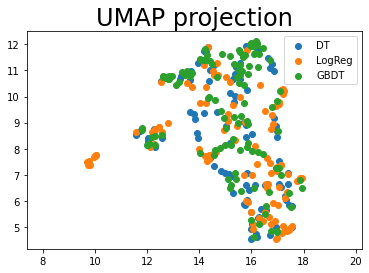

In [104]:
for k, v in {"DT":0, "LogReg":1, "GBDT":2}.items():
    plt.scatter(
    embeddings[:, 0][y == k],
    embeddings[:, 1][y == k],
    c=[sns.color_palette()[v]], label=k)
plt.legend()
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24);

In [105]:
y_encoded = label_encoder.fit_transform(y)

In [106]:
class NaivePredictor:
    def __init__(self):
        self.ans = 0

    def fit(self, _, y):
        self.ans = pd.Series(y).value_counts().argmax()

    def score(self, _, y_true):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y_true, np.full(y_true.shape, self.ans))

    def predict(self, X):
        return np.full(X.shape[0], self.ans)

In [109]:
algorithms = [
        DecisionTreeClassifier(max_depth=4),
        DecisionTreeClassifier(max_depth=8),
        LogisticRegressionCV(max_iter=100),
        LogisticRegressionCV(max_iter=1000),
        GradientBoostingClassifier(learning_rate=0.01, n_estimators=500),
        GradientBoostingClassifier(learning_rate=0.1, n_estimators=200),
        KNeighborsClassifier(n_neighbors=5),
        KNeighborsClassifier(n_neighbors=10),
        NaivePredictor()
    ]
descriptions = ['DT (max_depth=4)',
                'DT (max_depth=8)',
                'LogReg (max_iter=100)',
                'LogReg (max_iter=1000)',
                'GBDT (lr=0.01, n=500)',
                'GBDT (lr=0.1, n=200)',
                'KNN (n=5)',
                'KNN (n=10)',
                'NaivePredictor']
results = []
for name, algo in zip(descriptions, algorithms):
    pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', algo)])
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    scores = cross_val_score(pipeline, X, y_encoded, cv=skf)
    results.append(scores.mean())
    print(f'{name}: score - {scores.mean()} | std - {scores.std()}')

DT (max_depth=4): score - 0.45471153846153844 | std - 0.042064038334495624
DT (max_depth=8): score - 0.4922115384615385 | std - 0.03630925069993228
LogReg (max_iter=100): score - 0.4705769230769231 | std - 0.05115678309961047
LogReg (max_iter=1000): score - 0.5046634615384615 | std - 0.0361724456044365
GBDT (lr=0.01, n=500): score - 0.5298076923076923 | std - 0.0624463527153958
GBDT (lr=0.1, n=200): score - 0.5452884615384616 | std - 0.020054820393260012
KNN (n=5): score - 0.5201923076923076 | std - 0.027695395794695765
KNN (n=10): score - 0.4891346153846154 | std - 0.029450951476979622
NaivePredictor: score - 0.3021634615384615 | std - 0.006653054088027911


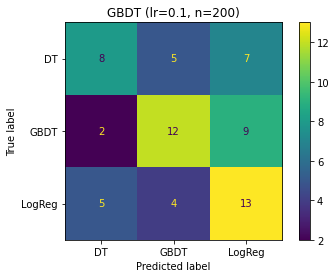

In [110]:
best_idx = np.argmax(results)
pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', algorithms[best_idx])])
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2,
                                                     random_state=12, stratify=y_encoded)
pipeline.fit(X_train, y_train)
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test,
                                                      display_labels=label_encoder.classes_)
plt.title(descriptions[best_idx])
plt.show()